In [1]:
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import os
import rioxarray as rio
import xarray as xr
# from dem_utils import ArcticDEM
# from itertools import product
# import dask
from dask.distributed import LocalCluster, Client
# import numpy as np
import pandas as pd
import numpy as np
from shapely import wkt
# import utils
# from shapely import wkt
import cartopy.crs as ccrs
# import planetary_computer as pc
# import pystac_client
# from pystac.extensions.eo import EOExtension as eo
# import rioxarray as rio
# import stackstac
import shapely


In [2]:
prj = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=-45,
    true_scale_latitude=70
)

Text(0, 0.5, 'sec (m/yr)')

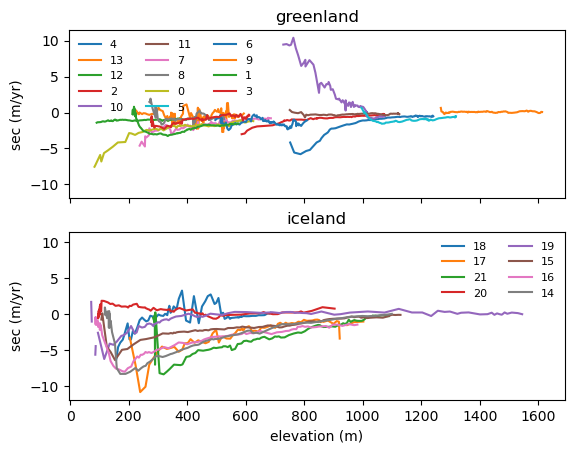

In [72]:
fig, axs = plt.subplot_mosaic([['greenland'],['iceland']], sharex=True, sharey=True)

directory = '../data/id5_-226289x_-2968847y/'
for directory in glob('../data/id*'):
    id = directory.split('id')[1].split('_')[0]
    
    centreline_filepath = glob('*.geojson', root_dir=directory)
    gdf = gpd.read_file(os.path.join(directory, centreline_filepath[0]))
    where = gdf.loc[0, 'where']
    
    sec_filepath = glob('sec.zarr', root_dir=directory)
    sec_filepath = os.path.join(directory, sec_filepath[0])
    z_filepath = glob('stacked*', root_dir=directory)
    z_filepath = os.path.join(directory, z_filepath[0])
    
    sec_along_line = sample_sec_along_line(sec_filepath)
    z_along_line = sample_sec_along_line(z_filepath, var='z')
    merged = xr.merge([sec_along_line.sel(result='slope').drop_vars('spatial_ref'),
                    z_along_line.median(dim='time')])

    merged[['z', 'sec']].to_dataframe().sort_values(by='z').plot(x='z', y='sec', label=id, ax=axs[where])
    
axs['greenland'].legend(fontsize=8, ncols=3, frameon=False, loc='upper right')
axs['iceland'].legend(fontsize=8, ncols=2, frameon=False)

axs['greenland'].set_title('greenland')
axs['iceland'].set_title('iceland')

axs['iceland'].set_xlabel('elevation (m)')
axs['iceland'].set_ylabel('sec (m/yr)')
axs['greenland'].set_ylabel('sec (m/yr)')

In [67]:
lgnd = axs['greenland'].get_legend()

In [68]:
lgnd.set_ncols(3)

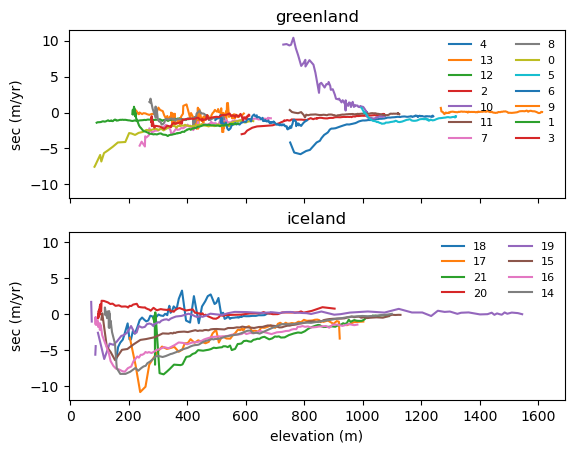

In [71]:
fig

In [20]:
def sample_sec_along_line(fp: str,
                          var=False):
    '''
    reads in .zarr of surface elevation change
    (i.e. the output of `dem_trends.py`)
    
    takes the centreline stored in .attrs['centreline']
    densifies it (to a total of 100 vertices)
    
    and samples the surface elvation change dataset
    (using .interp(), as opposed to .sel(method='nearest')
    at those points
    
    returning Dataset with dims `time`, `cumulative_distance`
    
    inputs: sec_file_path (str) 
    outputs xr.Dataset()
    '''
    
    assert(os.path.isdir(fp)), 'invalid path'
    with xr.open_dataset(fp, engine='zarr') as ds:
        
        centreline = shapely.wkt.loads(ds.attrs['centreline'])
        
        # densify line
        points = [centreline.interpolate(i/100, normalized=True)
                    for i in range(0, 100)]
        cumulative_distance = [centreline.project(p) for p in points]
        gdf_points = (gpd.GeoDataFrame(geometry=list(points),
                                        index=cumulative_distance,
                                        crs=3413
                                        ).rename_axis('cumulative_distance'))
        
        gdf_points['x'] = gdf_points['geometry'].x
        gdf_points['y'] = gdf_points['geometry'].y
        
        
        if var: ds = ds[var]
        
        # sample dataarrays
        sampled = ds.interp(x=gdf_points['x'].to_xarray(),
                            y=gdf_points['y'].to_xarray())
        
        return sampled

In [3]:
# add directory to centrelines geojson
centrelines = gpd.read_file('../data/streams_v3.geojson')
centrelines['directory'] = pd.Series()
for line in centrelines.itertuples():
    cntr = line.geometry.centroid
    centrelines.loc[line.Index, 'directory'] = f'../data/id{line.Index}_{cntr.x:.0f}x_{cntr.y:.0f}y'

In [47]:
def sample_sec(sec_file_path):
    with xr.open_dataset(sec_file_path, engine='zarr', chunks='auto') as ds:
        # print([ds.attrs.get(key) for key in ['median_threshold',
        #                                      'nmad_threshold']])
        centreline = shapely.wkt.loads(ds.attrs['centreline'])
        
        # densify line
        points = [centreline.interpolate(i/100, normalized=True)
                    for i in range(0, 100)]
        cumulative_distance = [centreline.project(p)/1000 for p in points]
        gdf_points = (gpd.GeoDataFrame(geometry=list(points),
                                        index=cumulative_distance,
                                        crs=3413
                                        ).rename_axis('cumulative_distance'))
        
        gdf_points['x'] = gdf_points['geometry'].x
        gdf_points['y'] = gdf_points['geometry'].y
        
        # sample dataarrays
        
        interpd = ds.interp(x=gdf_points['x'].to_xarray(),
                            y=gdf_points['y'].to_xarray())
        
        return interpd
    
def plot_result(ds, id, ax, plot_err=False):
    
    ds['sec'].sel(result='slope').plot(ax=ax, label=id)
    if plot_err:
        ax.fill_between(
            x=ds.cumulative_distance,
            y1=ds['sec'].sel(result='high_slope').data,
            y2=ds['sec'].sel(result='low_slope').data,
            color='lightgrey')
    ax.axhline(0, c='grey', lw=0.5)

In [44]:
import cartopy.feature as cfeature
from adjustText import adjust_text
from cycler import cycler

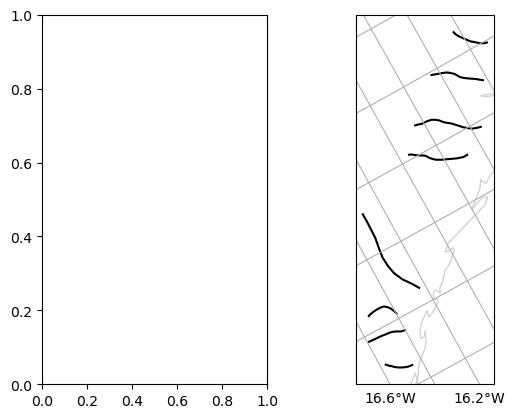

In [85]:
where = 'iceland'

colors = plt.get_cmap('tab20').colors

fig = plt.figure()

ax = fig.add_subplot(1,2,1)

ax.set_prop_cycle(cycler(color=colors))

axmap = fig.add_subplot(1,2,2, projection=prj)
axmap.add_feature(cfeature.COASTLINE, edgecolor='lightgrey')
centrelines.loc[centrelines['where']==where].plot(ax=axmap, color='k')
gl = axmap.gridlines(crs=ccrs.PlateCarree(),
                     draw_labels=True)
gl.rotate_labels=False
gl.bottom_labels=True
gl.left_labels=True
gl.top_labels=False
# gl.right_labels = True

# texts = []
# for i, row in enumerate(centrelines.loc[centrelines['where'] == where].itertuples()):
    
#     sec_file = glob('sec.zarr', root_dir=row.directory)
#     assert len(sec_file) == 1, 'not enough / too many files'
#     sec_file_path = os.path.join(row.directory, sec_file[0])
    
#     sampled = sample_sec(sec_file_path)
    
#     plot_result(sampled, row.Index, ax)
    
    
#     text = axmap.annotate(
#         text=row.Index,
#         xy=row.geometry.centroid.coords[0],
#         c=colors[i],
#         path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='lightgrey',
#                                                                  alpha=0.9,
#                                                                  offset=(1,-1))])
#     texts.append(text)
    
# _ = adjust_text(texts)

# # ax.legend(ncols=2, frameon=False)
# ax.set_title(None)
# ax.set_ylabel('surface elevation change (m/yr)')
# ax.set_xlabel('distance from terminus (km)')

# sns.despine(ax=ax)
# axmap.set_axis_off()
# plt.subplots_adjust(wspace=0.05)

# ax.set_title(where)

In [69]:
import seaborn as sns

In [13]:
import cartopy

In [19]:
import cartopy.feature




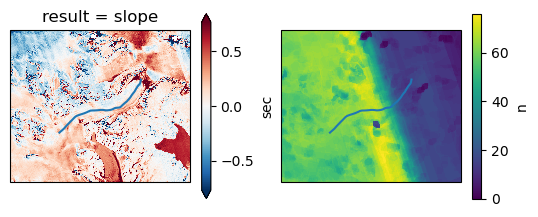

In [9]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection':prj})

with LocalCluster() as c, c.get_client() as cli:
    with xr.open_dataset('../data/id9_484789x_-1406074y/sec.zarr/',
                         engine='zarr') as ds:
        # counts = ds['z'].isnull().sum(dim=['x', 'y'])
        ds['sec'].sel(result='slope').plot(robust=True, ax=axs[0], cbar_kwargs={'shrink':0.5})
        ds['n'].plot(ax=axs[1], cbar_kwargs={'shrink':0.5})
        cl = wkt.loads(ds.attrs['centreline'])    

for ax in axs:
    ax.plot(*cl.coords.xy, c='k')


In [ ]:
import seaborn as sns
def plot_stat(df, stat, ax):
    # df = get_meta_df(d)
    after = f'{stat}_after'
    before = f'{stat}_before'
    for row in df.iterrows():
        # print(row[0])
        ax.annotate("",
                    xy=(row[1]['to_reg_acqdate1'], row[1][after]),
                    xytext=(row[1]['to_reg_acqdate1'], row[1][before]),
                    arrowprops=dict(arrowstyle='->'))
    
    minx, maxx = df['to_reg_acqdate1'].agg(['min','max'])
    delta = pd.Timedelta('90d')
    ax.set_xlim(minx-delta, maxx+delta)
    ax.set_ylim(*df[[after, before]].melt()['value'].agg(['min','max']))
    
    ax.axhline(0, c='lightgrey', lw=0.5)
    ax.axvline(df.ref_acqdate1.unique()[0], ls=':', c='k')
    ax.set_ylabel(f'{stat} (m)')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='center')

def plot_coreg(df, ax):
    # df = get_meta_df(d)
    
    plot_df = df[['median_after','median_before','nmad_after','nmad_before']].melt()
    plot_df['when'] = plot_df['variable'].str.split('_').apply(lambda x: x[1])
    plot_df['variable'] = plot_df['variable'].str.split('_').apply(lambda x: x[0])
    sns.violinplot(data=plot_df,
                   x='variable',
                   y='value',
                   hue='when',
                   palette=sns.palettes.color_palette('colorblind')[-2:],
                   hue_order=['before','after'],
                   ax=ax)
    ax.set_ylabel('metres')
    ax.set_xlabel(None)
    ax.axhline(0, c='lightgrey', lw=0.5, zorder=0)
    sns.move_legend(ax, loc='best', title=None)

## velocity

In [ ]:
from dask.distributed import Client, LocalCluster
import pandas as pd
# import itslive
import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely import box
import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.dates import date2num, DateFormatter, YearLocator
# import seaborn as sns
# import xrspatial as xrs
import numpy as np
import xarray as xr
from tqdm import tqdm
from IPython import display
import importlib
# import imagery
import utils
import velocity_helpers

In [ ]:
# _ = importlib.reload(utils)
# _ = importlib.reload(velocity_helpers)
# _ = importlib.reload(imagery)

In [ ]:
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

In [ ]:
## read in lines, and lazily get velocity cubes, centrelines, and robust trends
lines = gpd.read_file('../data/streams_v2.geojson').to_crs(3413)

In [ ]:
V = {}
failed = []
for row in tqdm(lines.sample(3).itertuples()):
    print(f'working on #{row.Index}')
    try:
        V[row.Index] = velocity_helpers.CentreLiner(
            geo=row.geometry,
            buff_dist=500,
            index=row.Index,
            filter_cube=False,
            get_robust_trend=True,
            get_annual_median=False,
            get_rgb=False,
            )
    except Exception as e:
        failed.append((row.Index, e))
        print(f'#{row.Index} did not work because\n{e}')
        continue

## plotting

In [ ]:
fig, axs = plt.subplots(figsize=[15,8],
                        nrows=2,
                        ncols=4,
                        sharex=True,
                        sharey=True)

for k_v, ax in zip(V.items(), axs.flat):
    k, v = k_v
    velocity_helpers.Plotters.rolling_median(v,
                                             ax=ax,
                                         **{'var': 'v',
                                            'ddt_range': ('335d','395d'),
                                            'ddt_bars': False,
                                            'col': 'cumul_dist',
                                            'window': '90d',
                                            'vals':[500, 1_000, 3_000, 5_000]
                                            })
    _point = utils.shapely_reprojector(v.point, 3413, 4326)
    
    ax.set_title(f'#{k}: {_point.y:.2f}N {_point.x:.2f}W\n{lines.loc[k,"name"]}')
    ax.minorticks_off()

# axs.flat[-2].remove()
axs.flat[-1].remove()

now = pd.Timestamp.now().strftime('%y%m%d_%H%M')+ '_'
directory = '../../GitHub/diary/journal_figures'
filename = 'iceland_outlets_annual_v.png'
fig.savefig(directory + now + filename, bbox_inches = 'tight')

In [ ]:
def centreline_theil_slopes(df, **kwargs):
    
    _var = kwargs.get('var', 'v')
    _x = kwargs.get('x', 'mid_date')
    _date_range = kwargs.get('date_range', (pd.Timestamp('1900-01-01'),
                                            pd.Timestamp.now()))
    _ddt_range = kwargs.get('ddt_range', ('0d', '30d'))
    _mad = kwargs.get('mad', 3)
    
    _df = df.loc[df[_x].between(*_date_range)]    

In [ ]:
idx = ((ds['date_dt'] > pd.Timedelta('335d')) & ((ds['date_dt'] <= pd.Timedelta('395d')))).compute()

from scipy.stats.mstats import theilslopes
from scipy.stats import linregress

x = (ds.mid_date[idx] - ds.mid_date[idx].min()) / pd.Timedelta('365.25d')
y = ds['v'][idx,50,50].compute()

nan_idx = y.isnull()

x = x[~nan_idx]
y= y[~nan_idx]

theil_result = theilslopes(y=y, x=x)
lr_result = linregress(x=x, y=y)


X = np.arange(0,30)
theil_fit = (X * theil_result.slope) + theil_result.intercept
lr_fit = (X * lr_result.slope) + lr_result.intercept

fig, ax = plt.subplots()
ax.scatter(x,y)

ax.plot(X, theil_fit, c='r', label='theilslopes')
ax.plot(X, lr_fit, c='g', label='lr')
ax.legend()

In [ ]:
fig, axs = plt.subplots(figsize=[15,8], nrows=5, ncols=3)
# get_velocity.Plotters.date_dt_bars(V[13],
#                                    ('1d','15d'),
#                                    ax=ax,
#                                    **{'vals':[5_000,1_000]})

get_velocity.Plotters.rolling_median(V[13],
                                     ('335d','395d'),
                                     ax=ax,
                                     ddt_bars=False,
                                     **{'var': 'v',
                                        'col': 'cumul_dist',
                                        'window': '180d',
                                        'vals':[1_000, 3_000, 5_000, 10_000]})

- look at underlying dodgy velocity images
TODO look at GRIMpP and MEASUREs

TODO
- PN thinks that relative change is sufficient to *control* for variations in glacier geometry (read: width/size).
- most interested in *relative* change of velocity over final few kilometers.
    - i.e. 

- it all comes from the same raw processed v data

## imagery

In [ ]:
study_sites = gpd.read_file('../data/potential_study_sites_v1.geojson')
study_sites = study_sites.loc[study_sites['notes'].isin(['yes', 'maybe'])]
study_sites.reset_index(drop=True, inplace=True)
study_sites_5k = study_sites.buffer(5_000).to_crs(4326)

In [ ]:
items = imagery.get_annual_median_mosaic(
    study_sites.loc[0,'geometry'],
    buffer_dist=15_000,
    src_crs=study_sites.crs,
    target_crs=4326,
    timeperiod='2023-01-01/2024-01-01',
    months=[8,9],
    )

In [ ]:
(xrs.multispectral.true_color(
    *items.squeeze()
    .transpose('band', 'y', 'x'))
 .plot.imshow(rgb='band')
)

In [ ]:
import stackstac
stackstac.stack(items, assets=['B04', 'B03', 'B02'])